


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.


CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

Build a gender classifier using the PyTorch library and a pretrained VGG-16 model on the CelebA dataset. 


- Freeze the convolutional layers of the pretrained model  
- Replace the classifier head with your own binary classification layer  
- Fine-tune the model on the given subset of CelebA  
- Experiment with different values of learning rate, batch size, and number of epochs  

**Dataset:** CelebA  
**Model:** VGG-16
**Library:** PyTorch  

---

## Software

 PyTorch framework offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.

## 2) Load training dataset

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/My Drive/CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
gender_data = data[['filename', 'Male']].copy()
gender_data.head()

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [ ]:
# This will extract the contents of the zip file into a folder named data
# Do not extract the zip into your google drive

!unzip "/content/drive/My Drive/CelebA30k.zip" -d "/content/data"

In [ ]:
first_image_path = os.path.join("/content/data/CelebA30k/", gender_data.loc[0,"filename"])
img = Image.open(first_image_path)

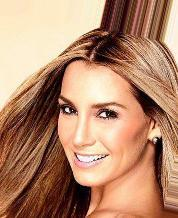

In [ ]:
img

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


Label Distribution:
Female    17320
Male      12680
Name: count, dtype: int64


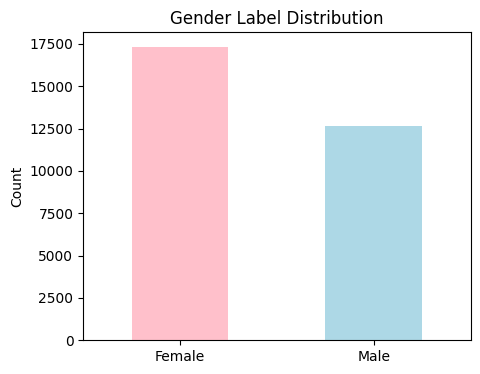

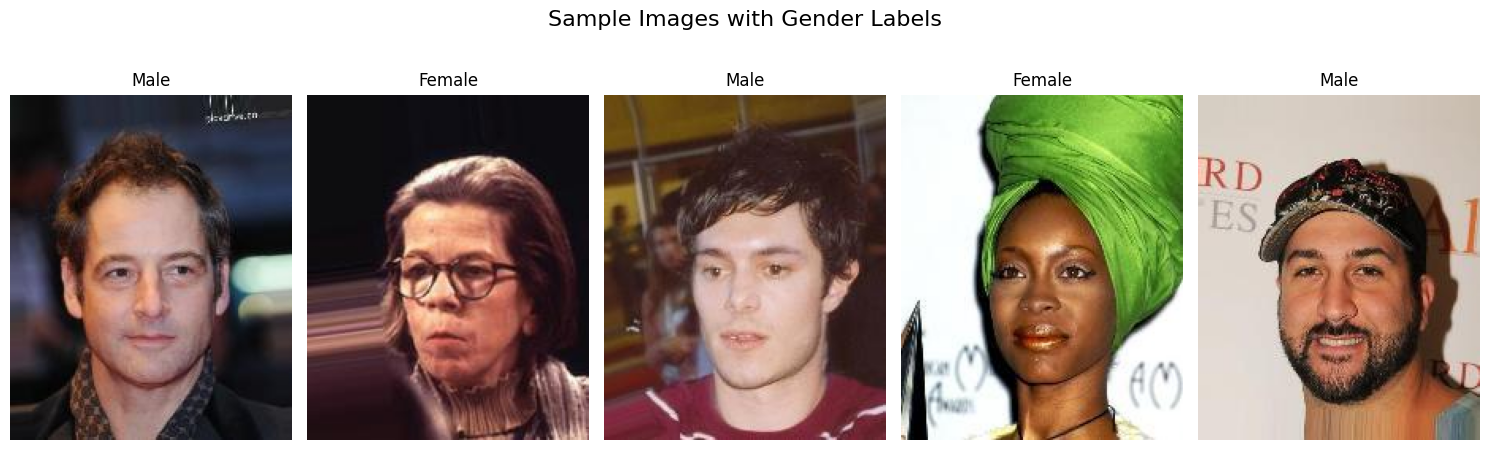

In [ ]:
# Set paths (adjust if using Google Drive or local)
csv_path = '/content/drive/MyDrive/CelebA30k.csv'
image_folder = '/content/data/CelebA30k'

# Load the CSV file
df = pd.read_csv(csv_path)

# Show label distribution
label_counts = df['Male'].value_counts().sort_index()
label_counts.index = ['Female', 'Male']
print("Label Distribution:")
print(label_counts)

# Plot label distribution
plt.figure(figsize=(5, 4))
label_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Gender Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Show 5 random images with their gender label
sample_rows = df.sample(5)
plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_path = os.path.join(image_folder, row['filename'])
    label = 'Male' if row['Male'] == 1 else 'Female'
    try:
        image = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

plt.suptitle('Sample Images with Gender Labels', fontsize=16)
plt.tight_layout()
plt.show()



##4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [ ]:
# First split: Train (80%) and Temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Male'], random_state=42)

# Second split: Validation (10%) and Test (10%) from Temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Male'], random_state=42)

# Convert -1 labels (Female) to 0
train_df['Male'] = train_df['Male'].replace(-1, 0)
val_df['Male'] = val_df['Male'].replace(-1, 0)
test_df['Male'] = test_df['Male'].replace(-1, 0)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


Train set: 24000 samples
Validation set: 3000 samples
Test set: 3000 samples


## 5) Preparing the Data

In this section, implement the dataset loading and preprocessing pipeline using PyTorch.

Provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Male`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5], [0.5]` for simplicity)
   - Add data augmentation (e.g., horizontal flip) for training
2. Write a custom `Dataset` class that reads images and labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size

In [ ]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CelebADataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['filename']
        label = self.dataframe.iloc[idx]['Male']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Paths
image_dir = '/content/data/CelebA30k'

# Dataset objects
train_dataset = CelebADataset(train_df, image_dir, transform=train_transform)
val_dataset = CelebADataset(val_df, image_dir, transform=val_transform)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Dataloaders ready.")


Dataloaders ready.


## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for gender classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with pretrained=True from torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [ ]:
# Loading pretrained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace the classifier head
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1)  # Output layer for binary classification
)


vgg16 = vgg16.to(device)

print("VGG-16 model loaded with custom classifier.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]


VGG-16 model loaded with custom classifier.


## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:
- Experiment with two different fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block and the classifier head, and train them.
- Choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- Use `nn.BCEWithLogitsLoss()` as the loss function.
  - Note: Since you are using nn.BCEWithLogitsLoss(), your model's output should not have a Sigmoid activation. This loss function applies the Sigmoid operation internally.
- Implement a training loop that includes validation after each epoch.
- Monitor both training and validation performance across epochs.

Hyperparameter Tuning:
- Try two different learning rates: 0.001 and 0.0001.
- The number of training epochs must be fixed to 10.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

Finally, you should report:
- Final training and validation accuracy for each configuration.
- A plot showing training and validation loss across epochs.
- A brief discussion comparing the results for different fine-tuning strategies and learning rates, identifying which combination performed best and why.



🔧 Training | LR: 0.001 | Unfreeze last block: False
Epoch 1/10 | Train Loss: 0.2727 | Val Loss: 0.2048 | Train Acc: 0.9173 | Val Acc: 0.9320
Epoch 2/10 | Train Loss: 0.1874 | Val Loss: 0.1905 | Train Acc: 0.9335 | Val Acc: 0.9347
Epoch 3/10 | Train Loss: 0.1788 | Val Loss: 0.1479 | Train Acc: 0.9406 | Val Acc: 0.9453
Epoch 4/10 | Train Loss: 0.1666 | Val Loss: 0.1682 | Train Acc: 0.9473 | Val Acc: 0.9430
Epoch 5/10 | Train Loss: 0.1484 | Val Loss: 0.1530 | Train Acc: 0.9529 | Val Acc: 0.9440
Epoch 6/10 | Train Loss: 0.1370 | Val Loss: 0.1525 | Train Acc: 0.9569 | Val Acc: 0.9427
Epoch 7/10 | Train Loss: 0.1310 | Val Loss: 0.1743 | Train Acc: 0.9590 | Val Acc: 0.9483
Epoch 8/10 | Train Loss: 0.1259 | Val Loss: 0.1810 | Train Acc: 0.9625 | Val Acc: 0.9410
Epoch 9/10 | Train Loss: 0.1297 | Val Loss: 0.1519 | Train Acc: 0.9607 | Val Acc: 0.9473
Epoch 10/10 | Train Loss: 0.1168 | Val Loss: 0.1614 | Train Acc: 0.9651 | Val Acc: 0.9480
Unique y_true_val: [0, 1]
Unique y_pred_val: [0, 1]


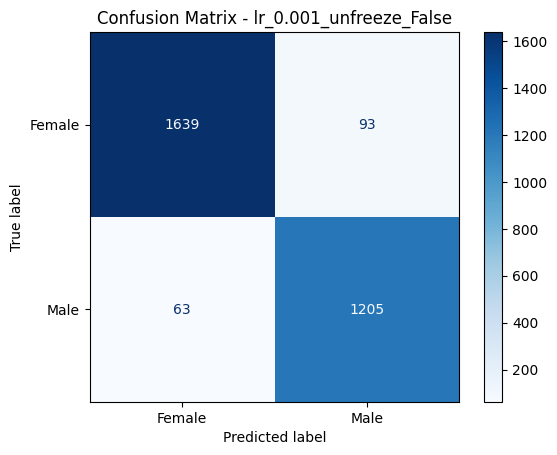

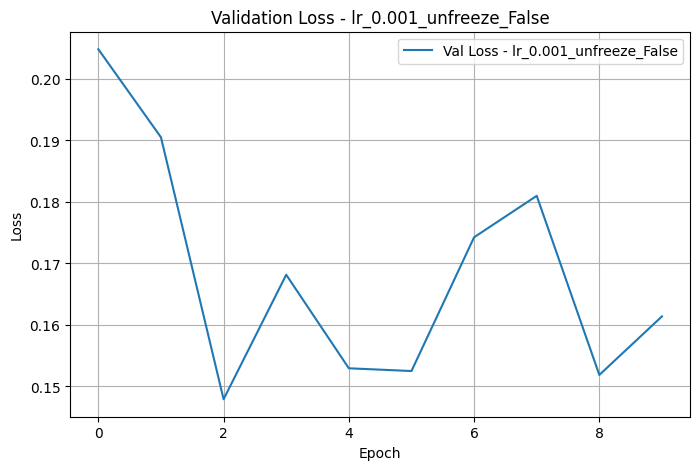

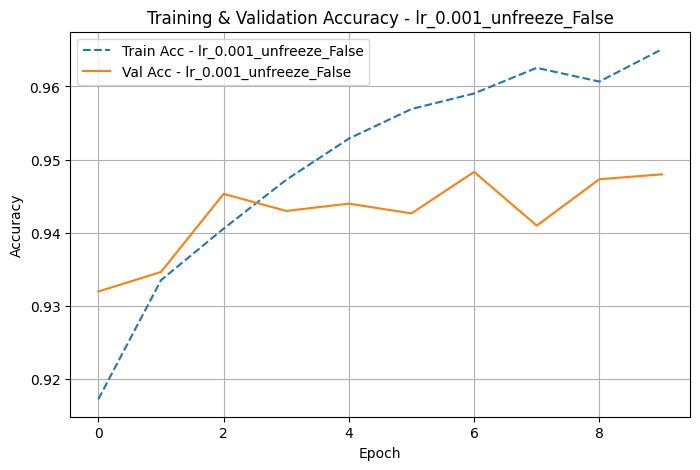


🔧 Training | LR: 0.0001 | Unfreeze last block: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 0.1885 | Val Loss: 0.1613 | Train Acc: 0.9272 | Val Acc: 0.9363
Epoch 2/10 | Train Loss: 0.1284 | Val Loss: 0.1551 | Train Acc: 0.9507 | Val Acc: 0.9440
Epoch 3/10 | Train Loss: 0.0993 | Val Loss: 0.1497 | Train Acc: 0.9629 | Val Acc: 0.9440
Epoch 4/10 | Train Loss: 0.0818 | Val Loss: 0.1545 | Train Acc: 0.9697 | Val Acc: 0.9480
Epoch 5/10 | Train Loss: 0.0699 | Val Loss: 0.1701 | Train Acc: 0.9741 | Val Acc: 0.9447
Epoch 6/10 | Train Loss: 0.0580 | Val Loss: 0.1571 | Train Acc: 0.9785 | Val Acc: 0.9540
Epoch 7/10 | Train Loss: 0.0461 | Val Loss: 0.1846 | Train Acc: 0.9836 | Val Acc: 0.9460
Epoch 8/10 | Train Loss: 0.0404 | Val Loss: 0.1948 | Train Acc: 0.9853 | Val Acc: 0.9483
Epoch 9/10 | Train Loss: 0.0359 | Val Loss: 0.2051 | Train Acc: 0.9872 | Val Acc: 0.9527
Epoch 10/10 | Train Loss: 0.0285 | Val Loss: 0.2112 | Train Acc: 0.9897 | Val Acc: 0.9533
Unique y_true_val: [0, 1]
Unique y_pred_val: [0, 1]


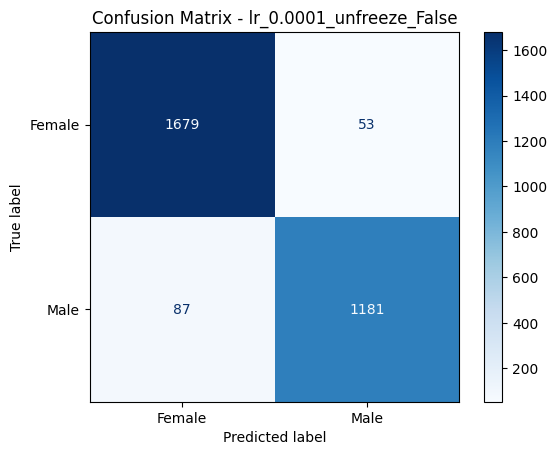

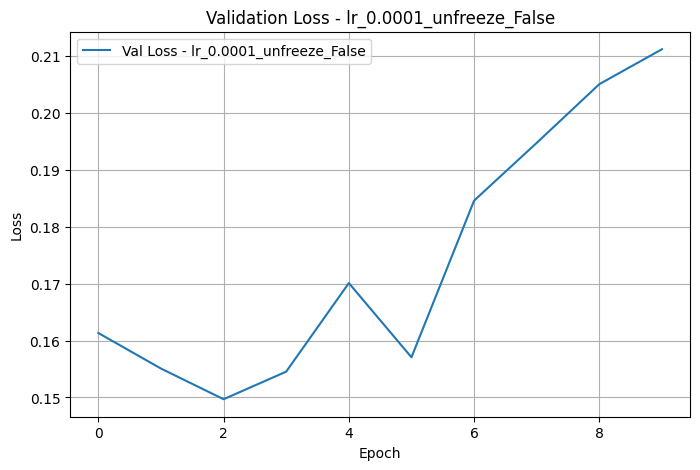

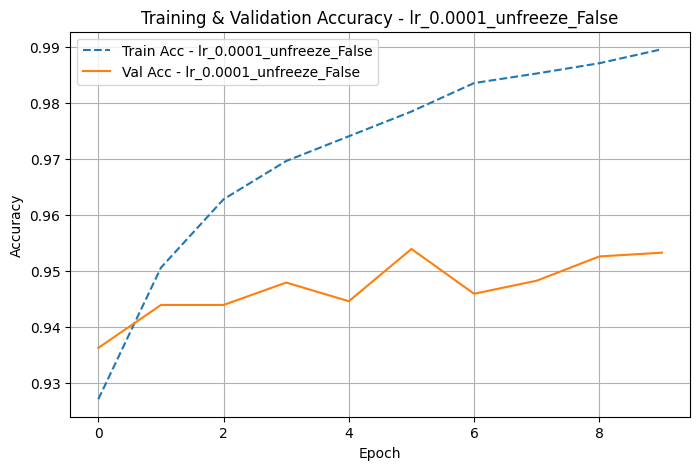


🔧 Training | LR: 0.001 | Unfreeze last block: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 0.6871 | Val Loss: 0.6814 | Train Acc: 0.5772 | Val Acc: 0.5773
Epoch 2/10 | Train Loss: 0.6820 | Val Loss: 0.6842 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 3/10 | Train Loss: 0.6817 | Val Loss: 0.6814 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 4/10 | Train Loss: 0.6817 | Val Loss: 0.6811 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 5/10 | Train Loss: 0.6816 | Val Loss: 0.6813 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 6/10 | Train Loss: 0.6817 | Val Loss: 0.6814 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 7/10 | Train Loss: 0.6815 | Val Loss: 0.6811 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 8/10 | Train Loss: 0.6816 | Val Loss: 0.6815 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 9/10 | Train Loss: 0.6812 | Val Loss: 0.6816 | Train Acc: 0.5773 | Val Acc: 0.5773
Epoch 10/10 | Train Loss: 0.6813 | Val Loss: 0.6813 | Train Acc: 0.5773 | Val Acc: 0.5773
Unique y_true_val: [0, 1]
Unique y_pred_val: [0]


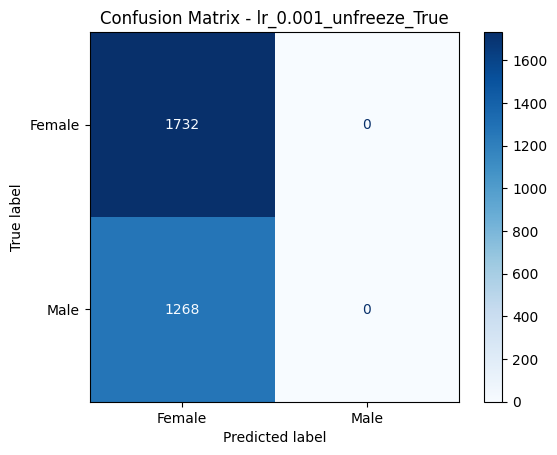

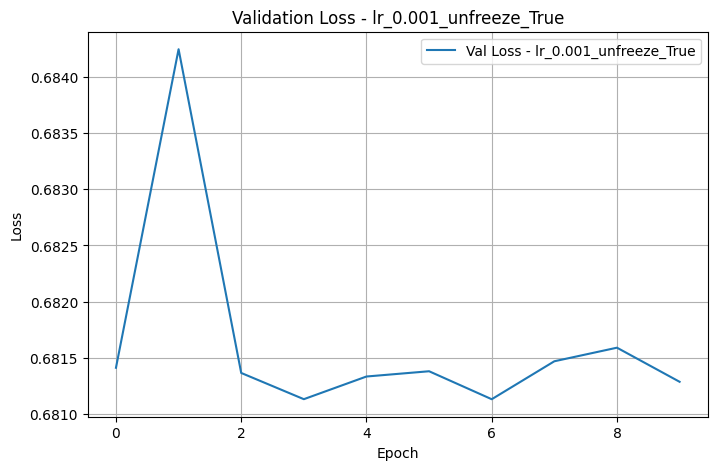

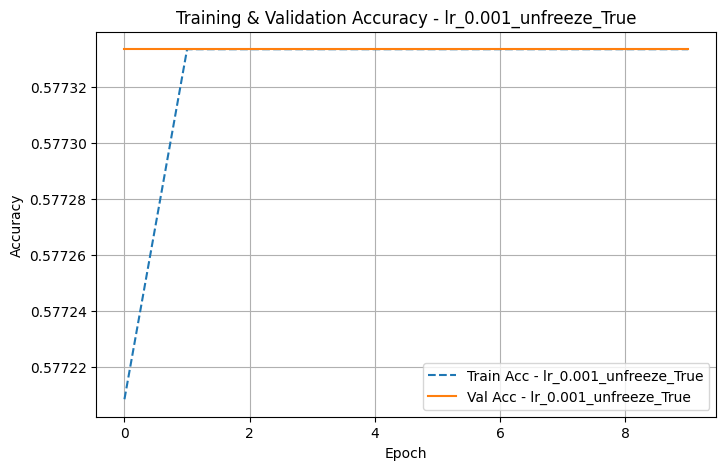


🔧 Training | LR: 0.0001 | Unfreeze last block: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 0.1252 | Val Loss: 0.1055 | Train Acc: 0.9523 | Val Acc: 0.9613
Epoch 2/10 | Train Loss: 0.0692 | Val Loss: 0.0722 | Train Acc: 0.9756 | Val Acc: 0.9737
Epoch 3/10 | Train Loss: 0.0523 | Val Loss: 0.0731 | Train Acc: 0.9813 | Val Acc: 0.9733
Epoch 4/10 | Train Loss: 0.0350 | Val Loss: 0.0962 | Train Acc: 0.9885 | Val Acc: 0.9753
Epoch 5/10 | Train Loss: 0.0333 | Val Loss: 0.0891 | Train Acc: 0.9886 | Val Acc: 0.9723
Epoch 6/10 | Train Loss: 0.0241 | Val Loss: 0.1099 | Train Acc: 0.9923 | Val Acc: 0.9747
Epoch 7/10 | Train Loss: 0.0204 | Val Loss: 0.0948 | Train Acc: 0.9933 | Val Acc: 0.9770
Epoch 8/10 | Train Loss: 0.0192 | Val Loss: 0.0891 | Train Acc: 0.9939 | Val Acc: 0.9707
Epoch 9/10 | Train Loss: 0.0144 | Val Loss: 0.0918 | Train Acc: 0.9950 | Val Acc: 0.9760
Epoch 10/10 | Train Loss: 0.0148 | Val Loss: 0.0991 | Train Acc: 0.9950 | Val Acc: 0.9750
Unique y_true_val: [0, 1]
Unique y_pred_val: [0, 1]


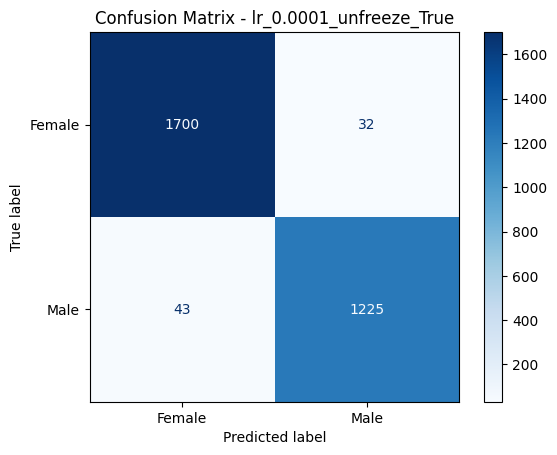

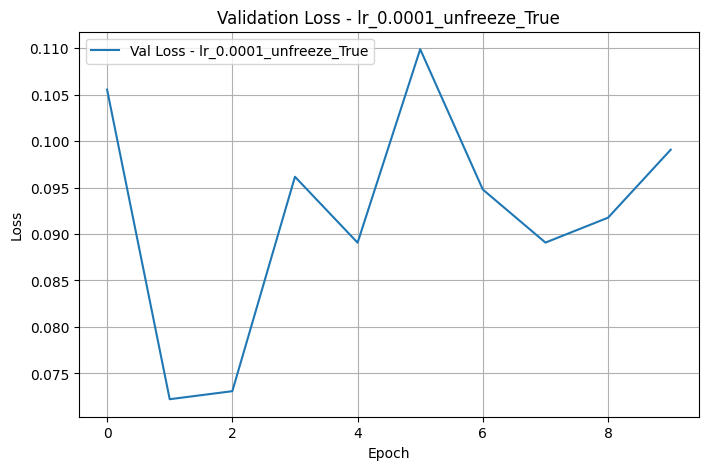

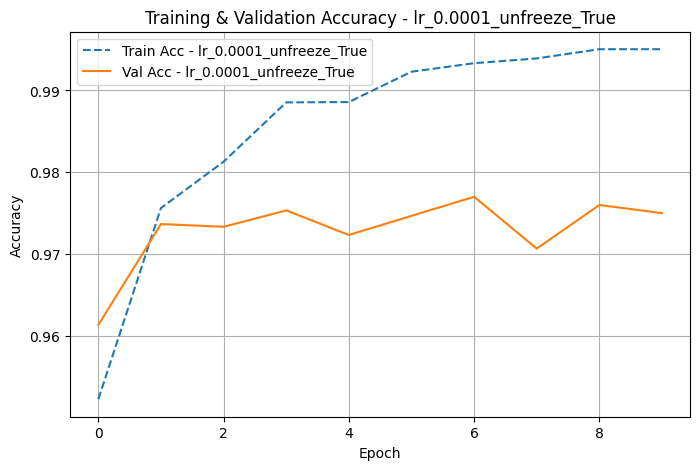

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# Helper to unfreeze last conv block
def unfreeze_last_conv_block(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.features[24:].parameters():
        param.requires_grad = True

# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    y_true_val_final, y_pred_val_final = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_pred_train += (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int).tolist()
            y_true_train += labels.cpu().numpy().astype(int).tolist()

        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
                y_pred_val += np.clip(preds.flatten(), 0, 1).tolist()
                y_true_val += labels.cpu().numpy().astype(int).flatten().tolist()

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if epoch == num_epochs - 1:
            y_true_val_final = y_true_val
            y_pred_val_final = y_pred_val

    return train_losses, val_losses, train_accuracies, val_accuracies, y_true_val_final, y_pred_val_final

# Configs to experiment
configs = [
    {"lr": 0.001, "unfreeze": False},
    {"lr": 0.0001, "unfreeze": False},
    {"lr": 0.001, "unfreeze": True},
    {"lr": 0.0001, "unfreeze": True}
]

results = {}

# Training all configs
for cfg in configs:
    print(f"\n🔧 Training | LR: {cfg['lr']} | Unfreeze last block: {cfg['unfreeze']}")

    model = models.vgg16(pretrained=True)

    if cfg['unfreeze']:
        unfreeze_last_conv_block(model)
    else:
        for param in model.features.parameters():
            param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 1)
    )
    model = model.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=cfg['lr'])
    criterion = nn.BCEWithLogitsLoss()

    # Training the model
    train_losses, val_losses, train_accs, val_accs, y_true_val, y_pred_val = train_model(
        model, train_loader, val_loader, optimizer, criterion, num_epochs=10
    )

    key = f"lr_{cfg['lr']}_unfreeze_{cfg['unfreeze']}"
    results[key] = {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }

    print("Unique y_true_val:", sorted(set(y_true_val)))
    print("Unique y_pred_val:", sorted(set(y_pred_val)))

    #  Confusion Matrix
    cm = confusion_matrix(y_true_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {key}")
    plt.show()

    #  Loss Curve for current experiment
    plt.figure(figsize=(8, 5))
    plt.plot(val_losses, label=f"Val Loss - {key}")
    plt.title(f"Validation Loss - {key}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    #  Accuracy Curve for current experiment
    plt.figure(figsize=(8, 5))
    plt.plot(train_accs, linestyle='--', label=f"Train Acc - {key}")
    plt.plot(val_accs, label=f"Val Acc - {key}")
    plt.title(f"Training & Validation Accuracy - {key}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



## 8) Test your classifier on Test set

- Use your model to predict the labels of the test set and report the final accuracy.

In [ ]:
# Prepare test set
test_dataset = CelebADataset(test_df, image_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            y_pred.extend(preds.flatten())
            y_true.extend(labels.cpu().numpy().astype(int).flatten())

    acc = accuracy_score(y_true, y_pred)
    print(f" Final Test Accuracy: {acc:.4f}")
    return acc

# best model
best_key = max(results, key=lambda k: results[k]['val_accs'][-1])
best_model = results[best_key]['model']

print(f"\n Best Configuration: {best_key}")
test_accuracy = evaluate_model(best_model, test_loader)



 Best Configuration: lr_0.0001_unfreeze_True
 Final Test Accuracy: 0.9733
